# Estimate deadtime by using data taken in the surface

#### Created by Jorge Torres, 6/16/2023

### Import needed libraries

In [1]:
import ROOT

import sys
import math

import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from scipy.stats import norm
from datetime import datetime
import statistics
from glob import glob

Welcome to JupyROOT 6.22/00


In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=14)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.linewidth'] = 1.2 # set the value globally

# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=22)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_327129/833492359.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


### Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [3]:
from dt5202 import dt5202_crunch

from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 50 #pedestal correction

In [4]:
#Import data files
# sourceFolder = "/data/board1771_01192023_retestingSwirlyPanel/"
sourceFolder = "/data/swirlyPanel_cs137_2min_ch0/"
#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory0
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
print(onlyfiles)
data_list = []
for file in onlyfiles:
    
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

['Run0_list.dat']
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1688070562298)]
((33, 0, 1.68807056e+09, 0, 1), (0, 3, 122, 982))


In [6]:
#Import data files
sourceFolder2 = "/data/swirlyPanel_2min_bkg/"
# sourceFolder = "/data/bigPanelTest_/"
#folder_name = os.getcwd() # could use this if analysis code is in the same directory as data
#loading all files in this directory0
onlyfiles = [f for f in os.listdir(sourceFolder2) if '.dat' in f]
print(onlyfiles)
data_list2 = []
for file in onlyfiles:
    
    data_list2.append(dt5202_crunch(str(sourceFolder2)+str(file), num_ev=100000000, num_ch=1))

data2 = data_list2[0]
for i in range(1, len(data_list2)):
    data2 = np.append(data2, data_list2[i])

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

['Run0_list.dat']
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1687894924983)]
((33, 0, 1.68789492e+09, 0, 1), (0, 3, 190, 1899))


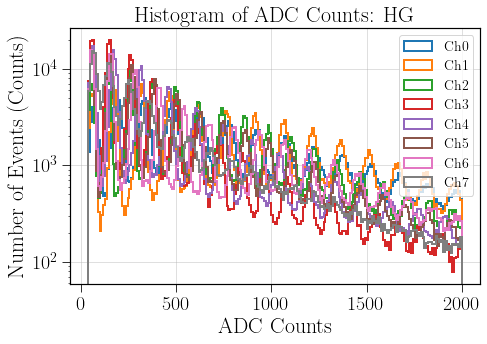

In [145]:
plt.figure(figsize=(7,5))
for ch in range(0,8):
    entries, bin_edges, _  = plt.hist(data['data']['high_gain'][:,ch], bins=200, range=(40,2000),
             histtype='step', label = "Ch%i"%ch, lw = 2);
#     plt.hist(data2['data']['low_gain'], bins=500, range=(0,9000),
#              histtype='step', label = "Swirly");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: HG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()

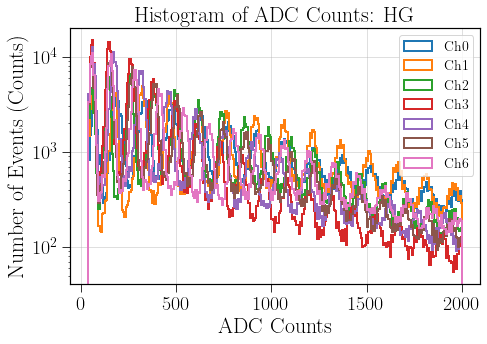

In [215]:
plt.figure(figsize=(7,5))
for ch in range(0,7):
    plt.hist(data['data']['high_gain'][:,ch], bins=300, range=(40,2000),
         histtype='step', label = "Ch%i"%ch, lw = 2);
#     plt.hist(data2['data']['low_gain'], bins=500, range=(0,9000),
#              histtype='step', label = "Swirly");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts: HG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()

In [147]:
bin_edges[200]

600.0

In [148]:
sum(entries[200:])/(10*25*25)

0.0

In [50]:
%cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
%cd -
from root_numpy import array2hist, hist2array, fill_hist

/home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
/home/coure/Iris_DT5202Analzer/dt5202_analysis


(0.0, 1000.0)

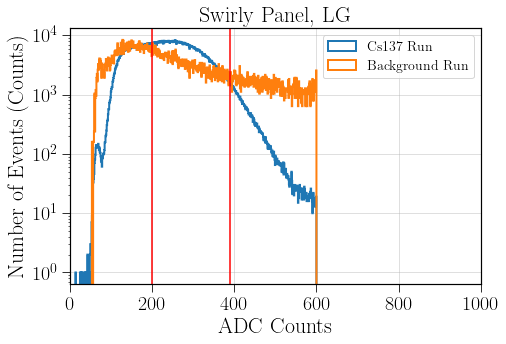

In [33]:
plt.figure(figsize=(7,5))
plt.hist(data['data']['low_gain'], bins=600, range=(0,600), histtype='step', label = "Cs137 Run", lw = 2);
plt.hist(data2['data']['low_gain'], bins=600, range=(0,600), histtype='step', label = "Background Run", lw = 2,
                                    weights=80*np.ones_like(data2['data']['low_gain']));
#     plt.hist(data2['data']['low_gain'], bins=500, range=(0,9000),
#              histtype='step', label = "Swirly");
#plt.xlim(3200,4500)
# plt.ylim(0,100000)
plt.axvline(200,color='red')
plt.axvline(390,color='red')


plt.yscale('log')
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Swirly Panel, LG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.xlim(0,1000)
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

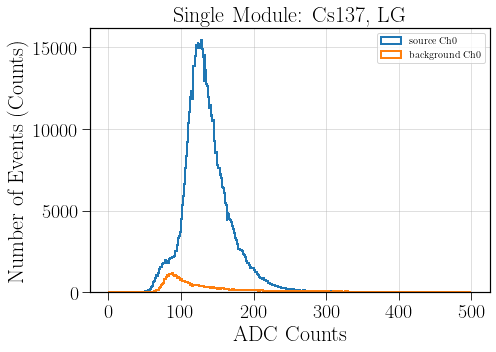

In [80]:
plt.figure(figsize=(7,5))
for ch in range(0,1):
    plt.hist(data['data']['low_gain'][:,0], bins=500, range=(0,500),
             histtype='step', label = "source Ch%i"%ch, lw = 2);
    plt.hist(data2['data']['low_gain'][:,0], bins=500, range=(0,500),
             histtype='step', label = "background Ch%i"%ch, lw = 2);
#     plt.hist(data2['data']['low_gain'], bins=500, range=(0,9000),
#              histtype='step', label = "Swirly");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)


# plt.yscale('log')
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Single Module: Cs137, LG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

 FCN=40.8102 FROM MIGRAD    STATUS=CALL LIMIT   1487 CALLS        1488 TOTAL
                     EDM=0.321842    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   3.28341e+01   1.72060e+00  -1.59791e-01  -1.18653e-01
   2  LandauMPV    1.56396e+02   2.61433e+01   1.32458e+01  -3.71060e-01
   3  Normalisation   1.60544e+04   3.10840e+03  -1.93535e+03  -2.13946e-03
   4  GaussianSigma   1.63671e+00   3.32903e-01  -3.77860e-02  -2.09938e+01
                               ERR DEF= 0.5


/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: Fit (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.


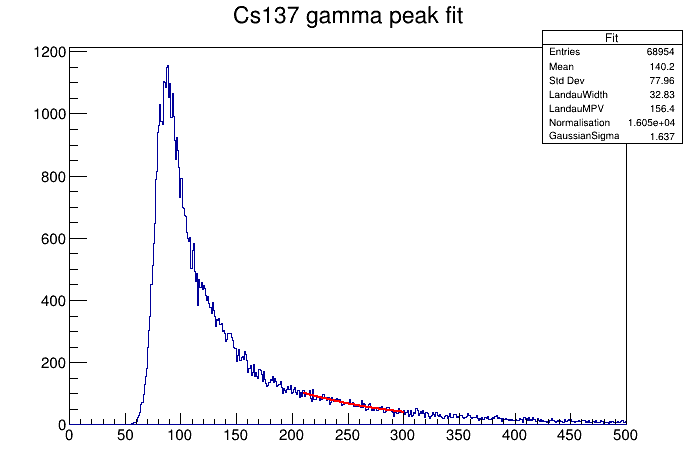

In [86]:
# Fit the muon peak and plot everything
c1 = ROOT.TCanvas('c1','')
hpx = ROOT.TH1D('Fit','Cs137 gamma peak fit',500,0,500)
hBkg = ROOT.TH1D('bkg', 'Background spectrum',500,0,500)
fill_hist(hpx, data2['data']['low_gain'][:,0])
hpx.Draw()
# ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx,fitrange=(210,300)) # this is the fit range, may need to tweak it 
hpx.Draw()
func.Draw("same")
hBkg.Draw("same")
c1.Draw()

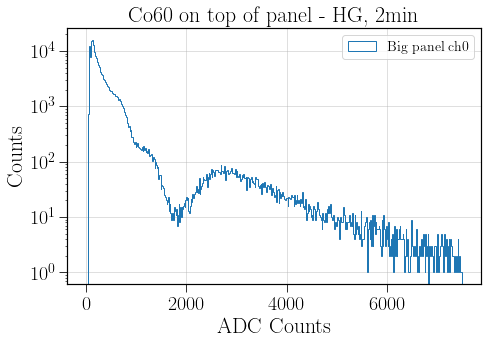

In [233]:
plt.figure(figsize=(7,5))
for ch in range(0,1):
    entries, bin_edges, _ = plt.hist(data2['data']['low_gain'], bins=500, range=(0,7500),
             histtype='step', label = "Big panel ch0");
#     plt.hist(data['data']['high_gain'], bins=500, range=(0,4000),
#              histtype='step', label = "Swirly panel");
#     plt.hist(data2['data']['high_gain'], bins=500, range=(0,4000),
#              histtype='step', label = "Swirly");
#plt.xlim(3200,4500)
# plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.title('Co60 on top of panel - HG, 2min')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# Can work on naming scheme
# plt.savefig('swirlyVsBiggerMod_Co60HG.pdf')
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

In [242]:
bin_edges[0]

0.0

In [239]:
sum(entries[120:])/(10*25*25)

1.26064

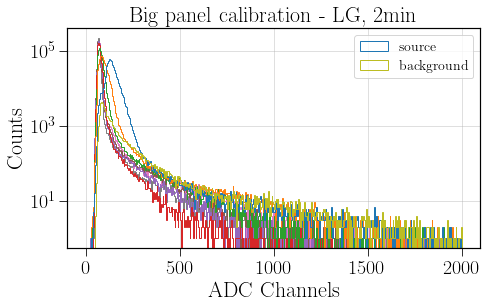

In [7]:
plt.figure(figsize=(7,4.5))
# for ch in range(0,1):
#     plt.hist(data['data']['low_gain'][:,ch], bins=500, range=(0,500),
#              histtype='step', label = "Ch%i"%ch);
# plt.hist(data['data']['low_gain'], bins=500, range=(0,4000),
#           histtype='step', label = "Ch0");
plt.hist(data['data']['low_gain'], bins=500, range=(0,2000),
          histtype='step', label = "source");
plt.hist(data2['data']['low_gain'][:,0], bins=500, range=(0,2000),
             histtype='step', label = "background");
# plt.hist(data['data']['high_gain'][:,1], bins=300, range=(0,3000),
#           histtype='step', label = "Swirly mini-module");
# # plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Channels')
plt.ylabel('Counts')
plt.title('Big panel calibration - LG, 2min')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# Can work on naming scheme
# plt.savefig('swirlyVsBiggerMod_Co60LG_zoomlin.pdf')

In [65]:
plt.figure(figsize=(7,5))
plt.hist(data['data']['low_gain'][:,0], bins=500, range=(0,8000),
         histtype='step', label = "Big panel");
plt.hist(data['data']['low_gain'][:,1], bins=500, range=(10,8000),
         histtype='step', label = "Swirly");
# plt.ylim(0,1000)
plt.yscale('log')

plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
# plt.title('Histogram of ADC Counts: Prototype Panel')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 504x360 with 0 Axes>

## Sum of energies for all channels

In [11]:
nEvents = np.shape(data['data']['low_gain'])[0]
nEvents_bkg = np.shape(data2['data']['low_gain'])[0]

In [12]:
energy_sum = np.ones(nEvents)
energy_sum_bkg = np.ones(nEvents_bkg)
for ch in range(0,8):
    energy_sum += data['data']['low_gain'][:,ch]
    energy_sum_bkg += data2['data']['low_gain'][:,ch]

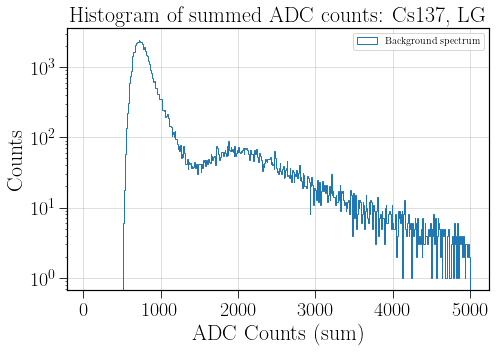

In [87]:
plt.figure(figsize=(7,5))
# plt.hist(energy_sum, bins=500, histtype='step', range=(40, 5000), label="Source spectrum"); 
plt.hist(energy_sum_bkg, bins=500, histtype='step', range=(40,5000), label="Background spectrum")
plt.yscale('log')
plt.xlabel('ADC Counts (sum)')
plt.ylabel('Counts')
plt.title('Histogram of summed ADC counts: Cs137, LG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
# plt.savefig("cs137_bigPanel_log.png")

In [ ]:
# Fit the muon peak and plot everything
c1 = ROOT.TCanvas('c1','')
hpx = ROOT.TH1D('Fit','Cs137 gamma peak fit',500,0,500)
hBkg = ROOT.TH1D('bkg', 'Background spectrum',500,0,500)
fill_hist(hpx, data2['data']['low_gain'][:,0])
hpx.Draw()
# ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx,fitrange=(210,300)) # this is the fit range, may need to tweak it 
hpx.Draw()
func.Draw("same")
hBkg.Draw("same")
c1.Draw()

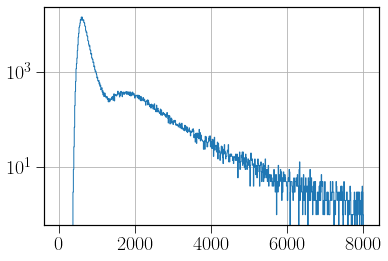

In [310]:
entries, bin_edges, _ = plt.hist(energy_sum, bins=700, histtype='step', range=(0, 8000));
plt.yscale("log")
plt.grid()

In [315]:
bin_edges[115]

1314.2857142857142

In [316]:
sum(entries[115:])/(10*100*50)

0.90252